In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import folium
import pandas as pd
import pypsa
from pypsa.linopt import get_var, linexpr, define_constraints
from geopy import distance
from geopy.geocoders import Nominatim
from time import sleep

%matplotlib inline

In [2]:
def get_network(years_select):
    # calls get_electrical_data to get string of the folder name containing the pypsa network csv files
    # imports pypsa network csv files
    # returns pypsa network to Case 1 / Case 2 / Case 3 script

    years_simulate = years_select
    network = pypsa.Network(get_electrical_data(years_simulate))

    return network


def get_electrical_data(years_elect):
    # returns string of the folder name containing the pypsa network csv files: buses, generators, storage_units & etc.

    if years_elect == '2030':
        return "C:/Users/work/pypsa_thesis/data/electrical/2030"
    elif years_elect == '2040':
        return "C:/Users/work/pypsa_thesis/data/electrical/2040"
    elif years_elect == '2050':
        return "C:/Users/work/pypsa_thesis/data/electrical/2050"


def calculate_annuity(n, r):
    # calculate the annuity factor for an asset with lifetime n years and
    # discount rate of r, e.g. annuity(20, 0.05) * 20 = 1.6
    # source: pypsa-eur add_electricity script
    # returns calculated annuity factor for the capital costs' calculation in get_techno_econ_data function

    if isinstance(r, pd.Series):
        return pd.Series(1 / n, index=r.index).where(r == 0, r / (1. - 1. / (1. + r) ** n))
    elif r > 0:
        return r / (1. - 1. / (1. + r) ** n)
    else:
        return 1 / n


def get_techno_econ_data(n_years, years_data, discount_rate, network):
    # calculates capital costs, marginal costs for generators, storage units, electrolysis, H2 pipelines
    # assign values for co2 emissions, efficiency
    # returns dataframe consist of above mentioned data

    network = network
    discount_rate = discount_rate
    n_years = n_years

    # loads techno economic parameters for different technologies based on pypsa technology-data repository
    if years_data == '2030':
        load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/techno_economic/pypsa_costs_2030.csv")
        df_load_data = pd.DataFrame(load_data)
    elif years_data == '2040':
        load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/techno_economic/pypsa_costs_2040.csv")
        df_load_data = pd.DataFrame(load_data)
    elif years_data == '2050':
        load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/techno_economic/pypsa_costs_2050.csv")
        df_load_data = pd.DataFrame(load_data)

    # correct units to MW
    df_load_data.loc[df_load_data.unit.str.contains("/kW"), "value"] *= 1e3

    # creates df which stores capital costs, marginal costs, efficiency and co2 emissions for generators, storage units,
    # electrolysis and H2 pipelines based on their 'carriers' names
    df_tech_costs = pd.DataFrame(columns=['carriers', 'capital_costs', 'marginal_costs', 'efficiency', 'co2_emissions'])
    df_tech_costs['carriers'] = list(network.carriers.index)
    df_tech_costs.set_index('carriers', inplace=True)

    # calculation of capital costs for different generation technologies
    # inspired from pypsa-eur add_electricity script
    # assign efficiency for different generation technologies
    for carrier_x in list(df_tech_costs.index):
        if carrier_x != 'H2' or carrier_x != 'Water_Reservoir':
            if carrier_x in list(df_load_data['technology']):
                if carrier_x not in ('Solar', 'Wind_Offshore', 'Wind_Onshore', 'H2_(g)_pipeline'):
                    df_cap_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_x])
                    lifetime = float(df_cap_cost[df_cap_cost['parameter'] == 'lifetime']['value'])
                    FOM = float(df_cap_cost[df_cap_cost['parameter'] == 'FOM']['value'])
                    investment = float(df_cap_cost[df_cap_cost['parameter'] == 'investment']['value'])
                    efficiency_x = float(df_cap_cost[df_cap_cost['parameter'] == 'efficiency']['value'])
                    df_tech_costs.at[carrier_x, 'capital_costs'] = round(((calculate_annuity(lifetime, discount_rate) +
                                                                           FOM / 100.) *
                                                                          investment * n_years), 2)
                    df_tech_costs.at[carrier_x, 'efficiency'] = efficiency_x
                else:
                    df_cap_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_x])
                    lifetime = float(df_cap_cost[df_cap_cost['parameter'] == 'lifetime']['value'])
                    FOM = float(df_cap_cost[df_cap_cost['parameter'] == 'FOM']['value'])
                    investment = float(df_cap_cost[df_cap_cost['parameter'] == 'investment']['value'])
                    df_tech_costs.at[carrier_x, 'capital_costs'] = round(((calculate_annuity(lifetime, discount_rate) +
                                                                           FOM / 100.) *
                                                                          investment * n_years), 2)
                    df_tech_costs.at[carrier_x, 'efficiency'] = 1.0

    # calculation of marginal costs for different generation technologies
    # inspired from pypsa-eur add_electricity script
    # assign efficiency for different generation technologies
    for carrier_y in list(df_tech_costs.index):
        if carrier_y in ('Biomass', 'CCGT', 'Coal', 'Lignite', 'Oil'):
            if carrier_y == 'CCGT':
                df_mar_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_y])
                VOM = float(df_mar_cost[df_mar_cost['parameter'] == 'VOM']['value'])
                fuel = float(
                    df_load_data[(df_load_data['parameter'] == 'fuel') & (df_load_data['technology'] == 'gas')][
                        'value'])
                efficiency_y = float(df_mar_cost[df_mar_cost['parameter'] == 'efficiency']['value'])
                df_tech_costs.at[carrier_y, 'marginal_costs'] = round(VOM + fuel / efficiency_y, 2)
            elif carrier_y == 'Biomass':
                fuel = float(
                    df_load_data[(df_load_data['parameter'] == 'fuel') & (df_load_data['technology'] == carrier_y)][
                        'value'])
                efficiency_y = float(df_load_data[(df_load_data['parameter'] == 'efficiency') & (
                        df_load_data['technology'] == carrier_y)]['value'])
                df_tech_costs.at[carrier_y, 'marginal_costs'] = round(fuel / efficiency_y, 2)
            else:
                df_mar_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_y])
                VOM = float(df_mar_cost[df_mar_cost['parameter'] == 'VOM']['value'])
                fuel = float(df_mar_cost[df_mar_cost['parameter'] == 'fuel']['value'])
                efficiency_y = float(df_mar_cost[df_mar_cost['parameter'] == 'efficiency']['value'])
                df_tech_costs.at[carrier_y, 'marginal_costs'] = round(VOM + fuel / efficiency_y, 2)

    # assign co2 emissions values for different generation technologies
    for carrier_z in list(df_tech_costs.index):
        if carrier_z in ('OCGT', 'CCGT', 'Coal', 'Lignite', 'Oil'):
            if carrier_z == 'OCGT' or carrier_z == 'CCGT':
                co2_intensity = float(df_load_data[(df_load_data['technology'] == 'Gas') &
                                                   (df_load_data['parameter'] == 'CO2 intensity')]['value'])
                df_tech_costs.at['{}'.format(carrier_z), 'co2_emissions'] = co2_intensity
            else:
                co2_intensity = float(df_load_data[(df_load_data['technology'] == '{}'.format(carrier_z)) &
                                                   (df_load_data['parameter'] == 'CO2 intensity')]['value'])
                df_tech_costs.at['{}'.format(carrier_z), 'co2_emissions'] = co2_intensity

    df_tech_costs.fillna(0, inplace=True)

    for x_carrier in list(df_tech_costs.index):
        for y_carrier, y_loc in zip(list(network.generators['carrier']), list(network.generators.index)):
            if x_carrier == y_carrier:
                cap_cost_x = df_tech_costs.at['{}'.format(x_carrier), 'capital_costs']
                mar_cost_x = df_tech_costs.at['{}'.format(x_carrier), 'marginal_costs']
                gen_efficiency_x = df_tech_costs.at['{}'.format(x_carrier), 'efficiency']
                network.generators.at['{}'.format(y_loc), 'capital_cost'] = cap_cost_x
                network.generators.at['{}'.format(y_loc), 'marginal_cost'] = mar_cost_x
                network.generators.at['{}'.format(y_loc), 'efficiency'] = gen_efficiency_x

    # capital costs, marginal costs, efficiency for storage units
    for p_carrier in list(df_tech_costs.index):
        for q_carrier, q_loc in zip(list(network.storage_units['carrier']), list(network.storage_units.index)):
            if p_carrier == q_carrier:
                cap_cost_p = df_tech_costs.at['{}'.format(p_carrier), 'capital_costs']
                mar_cost_p = df_tech_costs.at['{}'.format(p_carrier), 'marginal_costs']
                gen_efficiency_p = df_tech_costs.at['{}'.format(p_carrier), 'efficiency']
                network.storage_units.at['{}'.format(q_loc), 'capital_cost'] = cap_cost_p
                network.storage_units.at['{}'.format(q_loc), 'marginal_cost'] = mar_cost_p
                network.storage_units.at['{}'.format(q_loc), 'efficiency'] = gen_efficiency_p

    # co2 emissions for each carriers
    for r_carrier in list(df_tech_costs.index):
        for s_carrier in list(network.carriers.index):
            if r_carrier == s_carrier:
                co2_emi = df_tech_costs.at['{}'.format(r_carrier), 'co2_emissions']
                network.carriers.at['{}'.format(s_carrier), 'co2_emissions'] = co2_emi

    return df_tech_costs


def get_hydrogen_data(scenario_h2, years_h2, h2_config, network):
    # loads raw H2 demand data from Fraunhofer

    network = network
    if scenario_h2 == 'TN-H2-G':
        if years_h2 == '2030':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == '2040':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == '2050':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2050.csv",
                                    index_col=0)

    elif scenario_h2 == 'TN-PtG-PtL':
        if years_h2 == '2030':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == '2040':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == '2050':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2050.csv",
                                    index_col=0)

    elif scenario_h2 == 'TN-Strom':
        if years_h2 == '2030':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == '2040':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == '2050':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2050.csv",
                                    index_col=0)

    df_h2_demand = pd.DataFrame(load_data)
    df_h2_demand.index.names = ['location_name']
    df_h2_demand.reset_index(inplace=True)
    df_h2_demand.dropna(subset=['location_name'], inplace=True)
    df_h2_demand['demand_value'] = df_h2_demand['demand_value'].div(8760)  # from TWh/a to TW
    df_h2_demand['demand_value'] = df_h2_demand['demand_value'].multiply(1e6)  # from TW to MW
    x_coor = []
    y_coor = []

    for loc_count in range(len(df_h2_demand['location_name'])):
        geolocator = Nominatim(user_agent="locate_h2_demand")
        locate_h2_demand = geolocator.geocode(df_h2_demand['location_name'][loc_count].split(',')[0],
                                              timeout=None)
        x_coor.append(locate_h2_demand.longitude)
        y_coor.append(locate_h2_demand.latitude)
        sleep(1)

    df_h2_demand['x'] = x_coor
    df_h2_demand['y'] = y_coor
    df_ac_loads_h2_loads_dist = pd.DataFrame(index=network.loads.index, columns=df_h2_demand['location_name'])

    for city_count_x in range(len(network.loads.index)):
        for city_count_y in range(len(df_h2_demand['location_name'])):
            if network.loads.index[city_count_x] != df_h2_demand['location_name'][city_count_y]:
                city_1 = (network.loads['y'][city_count_x], network.loads['x'][city_count_x])
                city_2 = (df_h2_demand['y'][city_count_y], df_h2_demand['x'][city_count_y])
                dist_city1_city2 = distance.distance(city_1, city_2).km
                df_ac_loads_h2_loads_dist.at[
                    network.loads.index[city_count_x], df_h2_demand['location_name'][city_count_y]] = dist_city1_city2

    ac_loads_h2_links = []

    for column_count_x in df_ac_loads_h2_loads_dist.columns:
        for distance_count_x in range(len(df_ac_loads_h2_loads_dist[column_count_x])):
            if df_ac_loads_h2_loads_dist[column_count_x][distance_count_x] == \
                    df_ac_loads_h2_loads_dist[column_count_x].min():
                ac_loads_h2_links.append(df_ac_loads_h2_loads_dist.index[distance_count_x])

    ac_loads_h2_links = list(dict.fromkeys(ac_loads_h2_links))

    df_h2_buses_load = pd.DataFrame(index=ac_loads_h2_links, columns={'h2_load': [], 'x': [], 'y': []})

    for buses_count in range(len(network.buses.index)):
        for h2_buses_count in range(len(df_h2_buses_load.index)):
            if network.buses.index[buses_count] == df_h2_buses_load.index[h2_buses_count]:
                df_h2_buses_load['x'][h2_buses_count] = network.buses['x'][buses_count]
                df_h2_buses_load['y'][h2_buses_count] = network.buses['y'][buses_count]

    df_h2_buses_load.fillna(0, inplace=True)

    for column_count_y, i_count_y in zip(df_ac_loads_h2_loads_dist.columns, range(len(df_h2_demand['location_name']))):
        for distance_count_y in range(len(df_ac_loads_h2_loads_dist[column_count_y])):
            if df_ac_loads_h2_loads_dist[column_count_y][distance_count_y] == \
                    df_ac_loads_h2_loads_dist[column_count_y].min():
                h2_load_value = df_h2_demand[df_h2_demand['location_name'] == column_count_y]['demand_value'][
                    i_count_y]
                h2_demand_loc = df_ac_loads_h2_loads_dist.index[distance_count_y]
                if df_h2_buses_load.at[h2_demand_loc, 'h2_load'] == 0:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = h2_load_value
                else:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = df_h2_buses_load.at[h2_demand_loc, 'h2_load'] + \
                                                                    h2_load_value

    df_h2_pipelines_dist = pd.DataFrame(index=ac_loads_h2_links, columns=ac_loads_h2_links)

    for column_count_z in range(len(list(df_h2_pipelines_dist.index))):
        for row_count_z in range(len(list(df_h2_pipelines_dist.columns))):
            if df_h2_pipelines_dist.index[column_count_z] != df_h2_pipelines_dist.columns[row_count_z]:
                loc_1 = (df_h2_buses_load['y'][column_count_z], df_h2_buses_load['x'][column_count_z])
                loc_2 = (df_h2_buses_load['y'][row_count_z], df_h2_buses_load['x'][row_count_z])
                dist_loc_1_loc_2 = distance.distance(loc_1, loc_2).km
                df_h2_pipelines_dist.at[
                    df_h2_pipelines_dist.columns[row_count_z], df_h2_pipelines_dist.index[column_count_z]] = \
                    dist_loc_1_loc_2

    if h2_config == 'short':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_p in list(df_h2_pipelines_dist.columns):
            for city_count_q in range(len(list(df_h2_pipelines_dist.index))):
                if df_h2_pipelines_dist[city_count_p][city_count_q] == \
                        df_h2_pipelines_dist[city_count_p].min():
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_p, df_h2_pipelines_dist.index[city_count_q]))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_p))
                    h2_bus_1_list.append('{}_H2_Bus'.format(df_h2_pipelines_dist.index[city_count_q]))
                    bus_0_list.append(city_count_p)
                    bus_1_list.append(df_h2_pipelines_dist.index[city_count_q])
                    distance_km_list.append(df_h2_pipelines_dist[city_count_p].min())

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    elif h2_config == 'all':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_r in list(df_h2_pipelines_dist.columns):
            for city_count_s, i_count_s in zip(list(df_h2_pipelines_dist.index),
                                               range(len(list(df_h2_pipelines_dist.index)))):
                if city_count_r != city_count_s:
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_r, city_count_s))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_r))
                    h2_bus_1_list.append('{}_H2_Bus'.format(city_count_s))
                    bus_0_list.append(city_count_r)
                    bus_1_list.append(city_count_s)
                    distance_km_list.append(df_h2_pipelines_dist[city_count_r][i_count_s])

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    elif h2_config == 'short_fnb_2030':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_a in list(df_h2_pipelines_dist.columns):
            for city_count_b in range(len(list(df_h2_pipelines_dist.index))):
                if df_h2_pipelines_dist[city_count_a][city_count_b] == \
                        df_h2_pipelines_dist[city_count_a].min():
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_a, df_h2_pipelines_dist.index[city_count_b]))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_a))
                    h2_bus_1_list.append('{}_H2_Bus'.format(df_h2_pipelines_dist.index[city_count_b]))
                    bus_0_list.append(city_count_a)
                    bus_1_list.append(df_h2_pipelines_dist.index[city_count_b])
                    distance_km_list.append(df_h2_pipelines_dist[city_count_a].min())

        # after connecting the H2 pipelines based on shortest distance between the H2 buses
        # limitation #3: the remaining end points are connected MANUALLY roughly based on proposed FNB H2 network
        # below connections currently only for BW

        if scenario_h2 == 'TN-H2-G':
            fnb_2030_add = [['Eichstetten_110kV', 'Lorrach_110kV'],
                            ['KarlsruheWest_110kV', 'HeidelburgSud_110kV'],
                            ['Grossgartach_110kV', 'Kupferzell_110kV'],
                            ['Sindelfingen_110kV', 'Birkenfeld_110kV'],
                            ['Sindelfingen_110kV', 'Oberjettingen_110kV'],
                            ['Sipplingen_110kV', 'Markdorf_110kV'],
                            ['Biberach_110kV', 'Ravensburg_110kV'],
                            ['Goldshofe_110kV', 'Giengen_110kV']]

        elif scenario_h2 == 'TN-PtG-PtL':
            fnb_2030_add = [['KarlsruheWest_110kV', 'GKMannheim_110kV'],
                            ['KarlsruheWest_110kV', 'Sindelfingen_110kV'],
                            ['Sipplingen_110kV', 'Schmiechen_110kV'],
                            ['Pfahlbronn_110kV', 'Giengen_110kV']]

        elif scenario_h2 == 'TN-Strom':
            fnb_2030_add = [['Kuppenheim_110kV', 'Lorrach_110kV'],
                            ['KarlsruheWest_110kV', 'GKMannheim_110kV'],
                            ['KarlsruheWest_110kV', 'Stuttgart_110kV'],
                            ['Schmiechen_110kV', 'Laufen_an_der_Eyach_110kV'],
                            ['Pfahlbronn_110kV', 'Giengen_110kV']]

        for city_add in range(len(fnb_2030_add)):
            h2_pipe_row_list.append('{}_{}_h2_pipe'.format(fnb_2030_add[city_add][0], fnb_2030_add[city_add][1]))
            h2_bus_0_list.append('{}_H2_Bus'.format(fnb_2030_add[city_add][0]))
            h2_bus_1_list.append('{}_H2_Bus'.format(fnb_2030_add[city_add][1]))
            bus_0_list.append(fnb_2030_add[city_add][0])
            distance_km_list.append(df_h2_pipelines_dist.at[fnb_2030_add[city_add][0], fnb_2030_add[city_add][1]])

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    all_bus_list = bus_0_list + bus_1_list
    connected_list = []

    for city_check in ac_loads_h2_links:
        if city_check not in all_bus_list:
            print('{} not connected to any bus'.format(city_check))
        else:
            connected_list.append('{} is connected to a H2 bus'.format(city_check))

    dict_h2_data = {'h2_links': ac_loads_h2_links,
                    'h2_dataframe': df_h2_demand,
                    'h2_buses_load': df_h2_buses_load,
                    'h2_pipelines': df_h2_pipelines,
                    'h2_demand_value_total': round(sum(df_h2_demand['demand_value']) * 1e6, 2)}  # in MWh

    return dict_h2_data


def set_re_profile(network):
    network = network

    pmaxpu_generators = network.generators[
        (network.generators['carrier'] == 'Solar') |
        (network.generators['carrier'] == 'Run_of_River') |
        (network.generators['carrier'] == 'Wind_Offshore') |
        (network.generators['carrier'] == 'Wind_Onshore')]

    network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=pmaxpu_generators.index)

    network.generators_t.p_max_pu.loc[:, pmaxpu_generators.index] = pd.DataFrame(index=network.snapshots,
                                                                                 columns=pmaxpu_generators.index
                                                                                 )

    ac_data = pd.read_excel(
        "C:/Users/work/pypsa_thesis/data/electrical/ac_profile/ac_gen_20210101_20211231_transnetBW.xlsx")
    date_time_list = ac_data['Date'] + ' ' + ac_data['Time of day']
    ac_data.insert(0, 'timestamp', date_time_list)
    ac_data['timestamp'] = pd.to_datetime(ac_data['timestamp'])
    ac_data.drop(['Date', 'Time of day'], axis=1, inplace=True)
    ac_data = ac_data.set_index(pd.to_datetime(ac_data['timestamp']))
    ac_data_daily = ac_data.resample('D').mean()

    for col in list(ac_data_daily.columns):
        ac_data_daily[col] = ac_data_daily[col].div(24)  # MWh to MW

    for gen in list(network.generators_t.p_max_pu.columns):
        if 'ROF' in gen.split('_'):
            gen_profile = ac_data_daily['ROF'].div(pmaxpu_generators.at[gen, 'p_nom']).where(lambda df: df <= 1.,
                                                                                             other=1.)
            network.generators_t.p_max_pu[gen] = list(gen_profile)

    solar_data = pd.read_excel("C:/Users/work/pypsa_thesis/data/electrical/wind_solar_profile/solar_profile_2019.xlsx")
    wind_data = pd.read_excel("C:/Users/work/pypsa_thesis/data/electrical/wind_solar_profile/wind_profile_2019.xlsx")

    solar_data.set_index('start', inplace=True)
    solar_data_daily = solar_data.resample('D').mean().where(lambda df: df <= 1., other=1.)
    solar_profile_daily = list(solar_data_daily['DE'])

    wind_data.set_index('start', inplace=True)
    wind_data_daily = wind_data.resample('D').mean().where(lambda df: df <= 1., other=1.)
    wind_profile_daily = list(wind_data_daily['DE'])

    for re_loc in list(network.generators_t.p_max_pu.columns):
        if 'SOL' in re_loc.split('_'):
            network.generators_t.p_max_pu[re_loc] = solar_profile_daily

        elif 'WON' in re_loc.split('_'):
            network.generators_t.p_max_pu[re_loc] = wind_profile_daily




In [3]:
### Case - 1 ###
'''
user input for:
1) years to simulate
2) which h2 demand scenario
3) freq resolution in 1 year simulation - e.g. timesteps of: 24h / 12h / 6h / 1h 
4) annual discount rate of capital costs calculation for generators, storage units, electrolysis and H2 pipelines
5) which h2 pipeline connection configuration (applicable for Case 3 only)
'''

years = '2030'  # subset of {'2030', '2040', '2050'}
h2_scenario_demand = 'TN-H2-G'  # subset of {'TN-H2-G', 'TN-PtG-PtL', 'TN-Strom'}
freq = '24'
discount_rate = 0.07

'''
choose configuration of H2 pipelines connection (applicable for Case 3 only):
1) 'short' - buses which have H2 demand (which are H2 buses), will connect to any H2 buses in the shortest distance
2) 'all' - each H2 buses will connect to all other H2 buses regardless of short/long distances
3) 'short_fnb_2030' - connects using 'short' config first and then follows roughly similar to proposed H2 pipeline
                      connection based on FNB gas network development plan 2020 - 2030. This configuration currently
                      LIMITED ONLY for 'TN-H2-G' H2 scenario demand 
                    
'''
h2_pipe_config = 'short_fnb_2030'

### Case - 1 ###

# get electrical network from network csv files; generators, storage_units, lines, loads & etc.
# create snapshots based on chosen 'years' and timesteps 'freq' to simulate

network = get_network(years)

snapshots = pd.DatetimeIndex([])
period = pd.date_range(start='{}-01-01 00:00'.format(years),
                       freq='{}H'.format(freq),
                       periods=8760 / float(freq))
snapshots = snapshots.append(period)

network.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])

Nyears = network.snapshot_weightings.objective.sum() / 8760

'''

Nyears value depends on the snapshot resolution freq variable
Change of Nyears value will affect the calculation of capital cost based on pypsa-eur methodology from 
the add_electricity script

Nyears = network.snapshot_weightings.objective.sum() / 8760
Nyears

costs["capital_cost"] = ((annuity(costs["lifetime"], costs["discount rate"]) + 
                            costs["FOM"]/100.) *
                            costs["investment"] * Nyears)

'''
# calls get_techno_econ_data function to calculate capital costs, marginal costs, efficiency for generators,
# storage_units, electrolysis and H2 pipeline
# the function depends on Nyears (changes with the input value of 'freq' timesteps), years, discount rate
# append capital costs, marginal costs, efficiency and co2 emissions into network generators, storage_units and carriers
# the function returns network

techno_econ_data = get_techno_econ_data(Nyears, years, discount_rate, network)

# generates p_max_pu values for renewable generators based on data from open-power-system data repository:
# current p_max_pu snapshots only applicable for 365 days snapshots length (24H freq) - note on 26.06.2022
# gets profile for solar, wind, and hydro run-of-river

set_re_profile(network)

# current limitation #1: generates random AC loads/demand for Electrical Buses/Nodes

network.loads_t.p_set = pd.DataFrame(index=network.snapshots,
                                     columns=network.loads.index,
                                     data=1000 * np.random.rand(len(network.snapshots), len(network.loads)))

# calls get_hydrogen_data function to:
# acquire H2 demand data based on chosen H2 scenario demand 'h2_scenario_demand' and 'years' to simulate
# builds H2 pipeline configuration based on chosen H2 pipeline configuration 'h2_pipe_config

h2_data = get_hydrogen_data(h2_scenario_demand, years, h2_pipe_config, network)

# builds and connects H2 network with Electrical Buses/Nodes network
# creates H2 bus

network.add('Bus', 'Hydrogen', carrier='Hydrogen', x=8.5, y=49.0)

link_buses = h2_data['h2_links']

link_names = [s + '_Electrolysis' for s in link_buses]

# electrolysis capital cost and efficiency are based on DEA agency data and pypsa methodology calculations

electrolysis_cap_cost = techno_econ_data.at['Electrolysis', 'capital_costs']
electrolysis_efficiency = techno_econ_data.at['Electrolysis', 'efficiency']

# electrolysis_cap_cost = 0
# electrolysis_efficiency = 1

# connects Electrical Buses/Nodes with H2 Bus using Electrolysis Links

network.madd('Link',
             link_names,
             carrier='Hydrogen',
             capital_cost=electrolysis_cap_cost,
             p_nom_extendable=True,
             bus0=link_buses,
             bus1='Hydrogen',
             efficiency=electrolysis_efficiency)

# attach H2 Store to H2 Bus

network.add('Store', 'Store_Hydrogen', bus='Hydrogen', carrier='Hydrogen', e_nom_extendable=True)

INFO:pypsa.io:Imported network 2030 has buses, carriers, generators, global_constraints, lines, loads, storage_units, transformers


In [4]:
# inserts H2 total demand into the H2 constraint function

def hydrogen_constraints(n, snapshots):
    electrolysis_index = n.links.query('carrier == "Hydrogen"').index
    electrolysis_vars = get_var(n, 'Link', 'p').loc[n.snapshots[:], electrolysis_index]
    lhs = linexpr((1, electrolysis_vars)).sum().sum()
    total_production = h2_data['h2_demand_value_total']

    define_constraints(n, lhs, '>=', total_production, 'Link', 'global_hydrogen_production_goal')


def extra_functionality(n, snapshots):
    hydrogen_constraints(n, snapshots)

In [5]:
network.lopf(extra_functionality=extra_functionality, pyomo=False, solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-08
Read LP format model from file C:\Users\HPELIT~1\AppData\Local\Temp\pypsa-problem-5hyd3t0y.lp
Reading time = 2.28 seconds
obj: 376682 rows, 144922 columns, 1194593 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 376682 rows, 144922 columns and 1194593 nonzeros
Model fingerprint: 0x11141afe
Coefficient statistics:
  Matrix range     [5e-03, 4e+02]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+08, 1e+08]
  RHS range        [1e-01, 4e+08]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 284769 rows and 55776 columns
Presolve time: 1.82s
Presolved: 91913 rows, 89146 columns, 670996 nonzeros

Ordering time: 0.73s

Barrier statistics:
 Dense cols : 124
 Free vars  : 29926
 AA' NZ     : 8.324e+05
 Factor NZ  : 3.392e+06 (roughly 100 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.14e+10


('ok', 'optimal')

In [6]:
index_list = []
capital_costs = []
marginal_costs = []
efficiency = []
p_nom_opt_sum = []
capacity = []

for all_carr in list(techno_econ_data.index):
    if all_carr in list(network.generators['carrier'].unique()):
        index_list.append(all_carr)
        capital_costs.append(techno_econ_data.at['{}'.format(all_carr), 'capital_costs']) 
        marginal_costs.append(techno_econ_data.at['{}'.format(all_carr), 'marginal_costs'])
        efficiency.append(techno_econ_data.at['{}'.format(all_carr), 'efficiency'])
        p_nom_opt_sum.append(round(network.generators[network.generators['carrier'] == '{}'.format(all_carr)]['p_nom_opt'].sum(),2))
        capacity.append((network.generators[network.generators['carrier'] == '{}'.format(all_carr)]['p_nom'].sum()))
        
df_p_nom_opt_tech_cost = pd.DataFrame(index=index_list)
df_p_nom_opt_tech_cost.index.names = ['gen_type']
df_p_nom_opt_tech_cost['capital_costs (Euro/MW)'] = capital_costs
df_p_nom_opt_tech_cost['marginal_costs (Euro/MWh)'] = marginal_costs
df_p_nom_opt_tech_cost['efficiency'] = efficiency
df_p_nom_opt_tech_cost['p_nom_opt_sum (MW)'] = p_nom_opt_sum
df_p_nom_opt_tech_cost['capacity (MW)'] = capacity

su_index_list = []
su_capital_costs = []
su_marginal_costs = []
su_efficiency = []
su_p_nom_opt_sum = []
su_capacity = []

for su_all_carr in list(techno_econ_data.index):
    if su_all_carr in list(network.storage_units['carrier'].unique()):
        su_index_list.append(su_all_carr)
        su_capital_costs.append(techno_econ_data.at['{}'.format(su_all_carr), 'capital_costs']) 
        su_marginal_costs.append(techno_econ_data.at['{}'.format(su_all_carr), 'marginal_costs'])
        su_efficiency.append(techno_econ_data.at['{}'.format(su_all_carr), 'efficiency'])
        su_p_nom_opt_sum.append(round(network.storage_units[network.storage_units['carrier'] == '{}'.format(su_all_carr)]['p_nom_opt'].sum(),2))
        su_capacity.append((network.storage_units[network.storage_units['carrier'] == '{}'.format(su_all_carr)]['p_nom'].sum()))
        
df_su_p_nom_opt_tech_cost = pd.DataFrame(index=su_index_list)
df_su_p_nom_opt_tech_cost.index.names = ['gen_type']
df_su_p_nom_opt_tech_cost['capital_costs (Euro/MW)'] = su_capital_costs
df_su_p_nom_opt_tech_cost['marginal_costs (Euro/MWh)'] = su_marginal_costs
df_su_p_nom_opt_tech_cost['efficiency'] = su_efficiency
df_su_p_nom_opt_tech_cost['p_nom_opt_sum (MW)'] = su_p_nom_opt_sum
df_su_p_nom_opt_tech_cost['capacity (MW)'] = su_capacity

df_gen_p_nom_opt_costs = pd.concat([df_p_nom_opt_tech_cost, df_su_p_nom_opt_tech_cost])
df_gen_p_nom_opt_costs.sort_values(by='p_nom_opt_sum (MW)', ascending=False)

,capital_costs (Euro/MW),marginal_costs (Euro/MWh),efficiency,p_nom_opt_sum (MW),capacity (MW)
gen_type,,,,,
Biomass,11586.79,14.89,0.47,1060520.12,264.8
Wind_Onshore,4003.58,0.00,1.00,6278.87,261.5
CCGT,4126.16,38.86,0.58,10.29,1194.9
Run_of_River,12464.18,0.00,0.90,0.00,612.0
Solar,1937.87,0.00,1.00,0.00,150.0
Coal,14582.36,28.20,0.33,0.00,5961.7
Oil,1577.95,148.86,0.35,0.00,701.8
Pumped_Storage,7389.38,0.00,0.75,0.00,1875.0


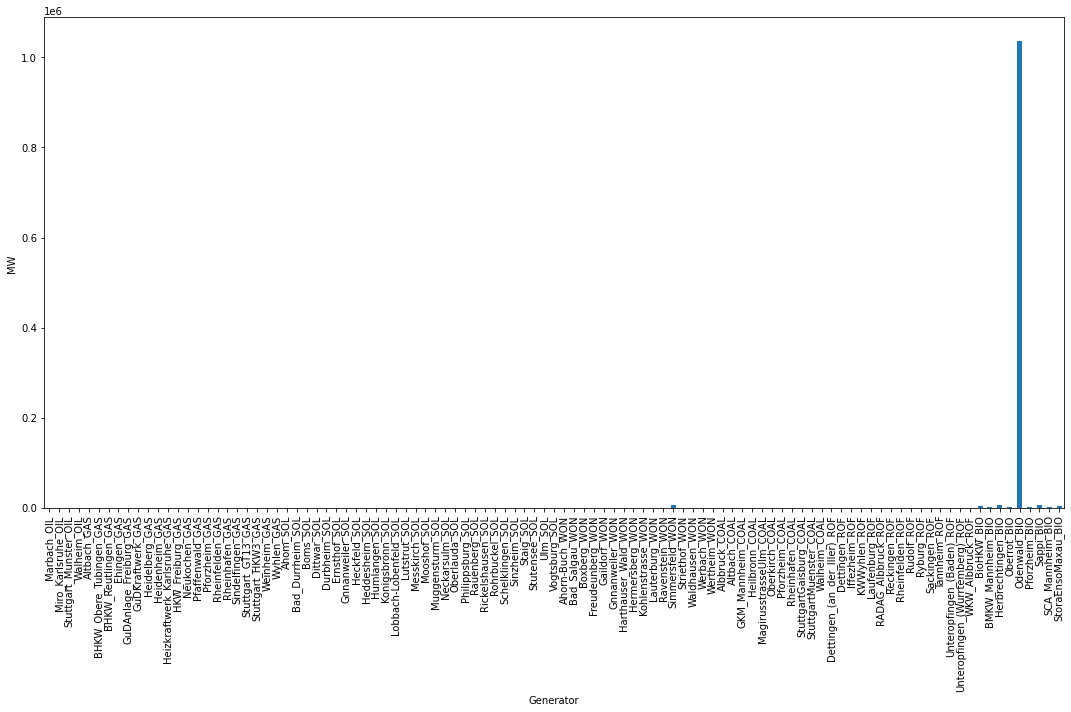

In [7]:
network.generators.p_nom_opt.plot.bar(ylabel='MW', figsize=(15,10))
plt.tight_layout()

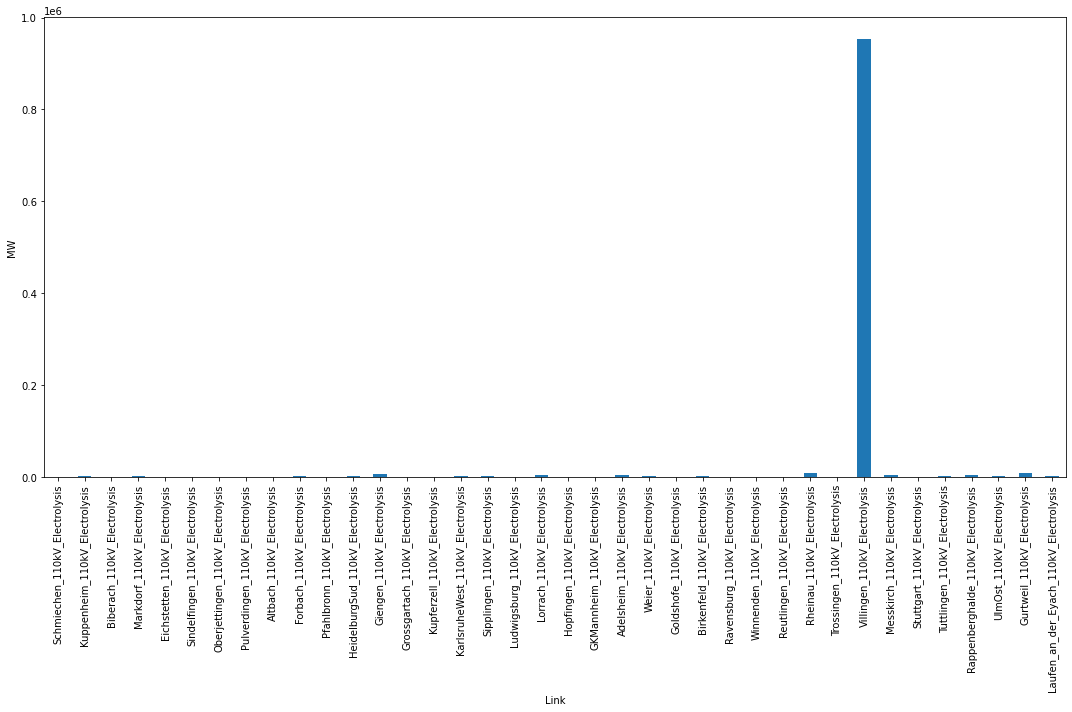

In [8]:
network.links.p_nom_opt.plot.bar(ylabel='MW', figsize=(15,10))
plt.tight_layout()

In [9]:
round(network.links.p_nom_opt.sum(),2)

1015123.08

In [10]:
network.links.p_nom_opt.sort_values(ascending=False).head()

Link
Villingen_110kV_Electrolysis          952726.016872
Gurtweil_110kV_Electrolysis             8548.385914
Rheinau_110kV_Electrolysis              7860.717453
Giengen_110kV_Electrolysis              5693.403479
Rappenberghalde_110kV_Electrolysis      4436.646587
Name: p_nom_opt, dtype: float64

In [11]:
str_unit_carr = list(np.unique(list(network.stores.carrier)))

df_stor_p_nom_opt = pd.DataFrame(index=str_unit_carr)

str_p_nom_opt_list = []
str_p_nom_list = []

for carr_count_z in range(len(str_unit_carr)):
    p_nom_opt_sum_z = network.stores[network.stores['carrier'] == '{}'.format(str_unit_carr[carr_count_z])]['e_nom_opt'].sum()
    p_nom_sum_z = network.stores[network.stores['carrier'] == '{}'.format(str_unit_carr[carr_count_z])]['e_nom'].sum()
    str_p_nom_opt_list.append(round(p_nom_opt_sum_z,2))
    str_p_nom_list.append(round(p_nom_sum_z,2))
    

df_stor_p_nom_opt['capacity e_nom_sum (MWh)'] = str_p_nom_list
df_stor_p_nom_opt['e_nom_opt_sum (MWh)'] = str_p_nom_opt_list  

df_stor_p_nom_opt        

,capacity e_nom_sum (MWh),e_nom_opt_sum (MWh)
Hydrogen,0.0,2.438918e+08
